<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/TutorialBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Credits:* Based on [code written by A. Géron](https://github.com/ageron/handson-ml2) for his book ""Hands-on ML with scikit-learn, keras and tensorflow.", 2nd edition 2019, O'Reilly Media. Code realeased under [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).


# Boosting Tutorial


In [1]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats


## AdaBoost

### Some useful plotting functions

In [2]:
from matplotlib.colors import ListedColormap

def plot_data(X, y, ax=None, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5,):
    if ax is None:
        ax = plt.gcf().gca()
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$", fontsize=18)
    ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

def plot_decision_boundary(clf, X, y, ax=None, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    if ax is None:
        ax = plt.gcf().gca()
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plot_data(X, y, ax=ax, axes=axes, alpha=alpha)


### Some toy data to demonstrate the algorithms

Let's use the moons dataset for binary classification:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

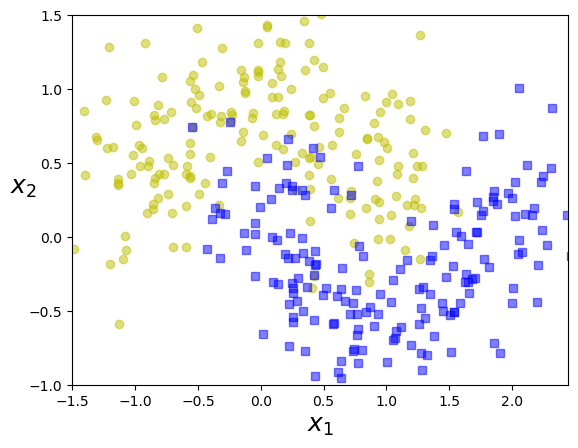

In [4]:
plot_data(X_train, y_train)

### AdaBoost using SVM as a base model

This example implements AdaBoost manually, using SVM classifiers as a base model.

At the end, we plot the decision function corrsponding to the final mode, along with the decision boundaries of each of the 5 models.


Text(1.36, -0.95, '5')

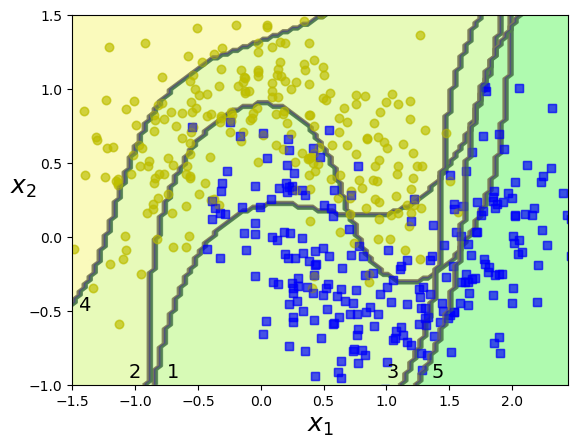

In [5]:
from sklearn.svm import SVC

m = X_train.shape[0] # n samples

# Initialize sample weights
sample_weights = np.ones(m) / m

for i in range(5):
    # Let us fit a new learner Fm
    model_F = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
    # We can pass the weight samples to the fit call so that
    # they get applied in the loss function
    model_F.fit(X_train, y_train, sample_weight=sample_weights * m)
    y_pred = model_F.predict(X_train)

    # Once Fm is fit, we compute its normalized error
    # TODO complete the line bellow with the expression for err
    err = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
    # Then we compute the model weight alpha
    # TODO complete the line bellow with the expression for alpha=2*beta
    alpha = np.log((1 - err) / err)
    # Now we update the sample wheights only for misclassified samples
    # TODO complete the line bellow with the sample update
    sample_weights[y_pred != y_train] *= np.exp(alpha) 
    # Before we continue, we renormalize the weights
    sample_weights /= sample_weights.sum() # normalization step

    plot_decision_boundary(model_F, X, y, alpha=0.2)

plt.text(-0.75, -0.95, "1", fontsize=14)
plt.text(-1.05, -0.95, "2", fontsize=14)
plt.text(1.0, -0.95, "3", fontsize=14)
plt.text(-1.45, -0.5, "4", fontsize=14)
plt.text(1.36,  -0.95, "5", fontsize=14)

#### Adding a learning rate
As in any boosting algorithm, AdaBoost combines models additively. Each model has an associated weight $\alpha_m$ that can be adjusted according to its mistakes on the training set. 
$$f_m(x) = f_{m-1}(x)+\alpha_m F_m(x)$$

From the decision function plot we observe that not all boundaries are very helpful in defining an accurate decision function.
In particular, the boundaries learned by the later models (3, 4 and 5) are quite distant from where the ideal boundary should be. This is normal and is due to these later models focusing more on the few samples misclassified by the previous models. 

However, it would be better to give these models less weight in the model combination. This can be achieved by including a learning rate hyperparameter, as follows.
Along the model weight $\alpha_m$, the algorithm can adjusted to include a learning rate hyperparameter $\nu$ that further regulates how much each new model $F_m$ will impact the final decision function:

$$f_m(x) = f_{m-1}(x)+\nu\alpha_m F_m(x)$$


When this value is small (typically lower than 1), it is also known as *shrinkage factor*, as it reduces the influence of new models $F_m$ being learned.


This next example implements the same algorithm, but tries out a learning rate of 0.5.

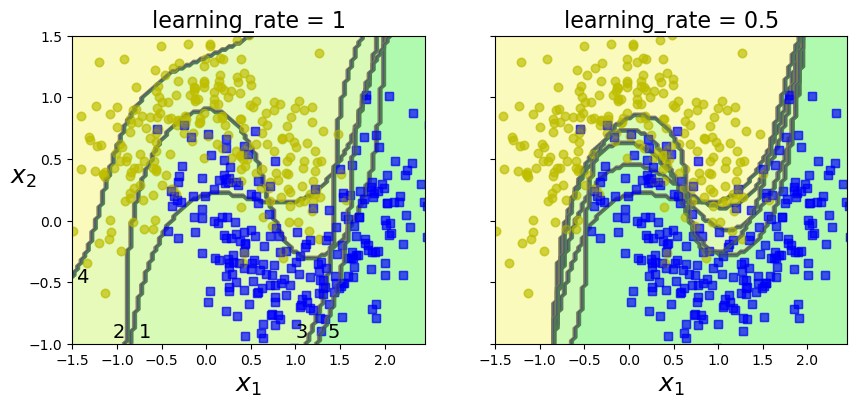

In [6]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        # Let us fit a new learner Fm
        model_F = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        model_F.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = model_F.predict(X_train)

        # Once Fm is fit, we compute its normalized error
        # TODO complete the line bellow with the expression for err
        err = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        # Then we compute the model weight alpha
        # TODO complete the line bellow with the expression for alpha=2*beta
        alpha = np.log((1 - err) / err)
        # Now we update the sample wheights only for misclassified samples
        # TODO complete the line bellow with the sample update
        # NOTE in this version, the original alpha is replaced 
        # by alpha x learning_rate
        sample_weights[y_pred != y_train] *= np.exp(learning_rate * alpha) 
        # Before we continue, we renormalize the weights
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(model_F, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

Notice how the decision boundaries are now less deviant from the class frontier and how the final decision function is sharper around it.

### AdaBoost with decision trees on Scikit-Learn

A common version of AdaBoost is to use very short decision trees as a base model, with only one level bellow the root node. These short trees are cften called *decision stumps*. 

Here is an example implementing AdaBoost with trees of depth 1 with Scikit-learn:

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=5,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=5, random_state=42)

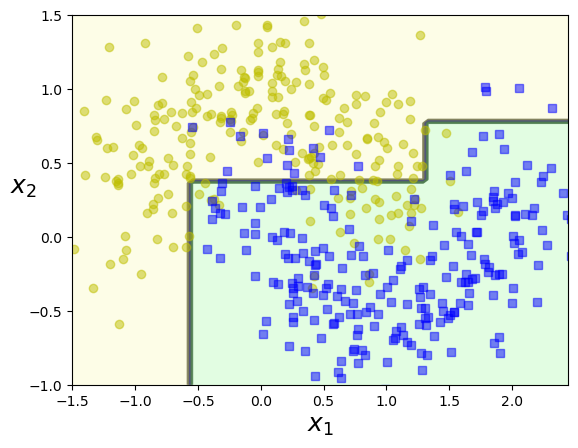

In [8]:
plot_decision_boundary(ada_clf, X, y)

#### About the number of estimators
Since the base models are much weaker than SVM, it is normal that we should add many more to the ensemble to get a more accurate classification. Let's try again with more trees:

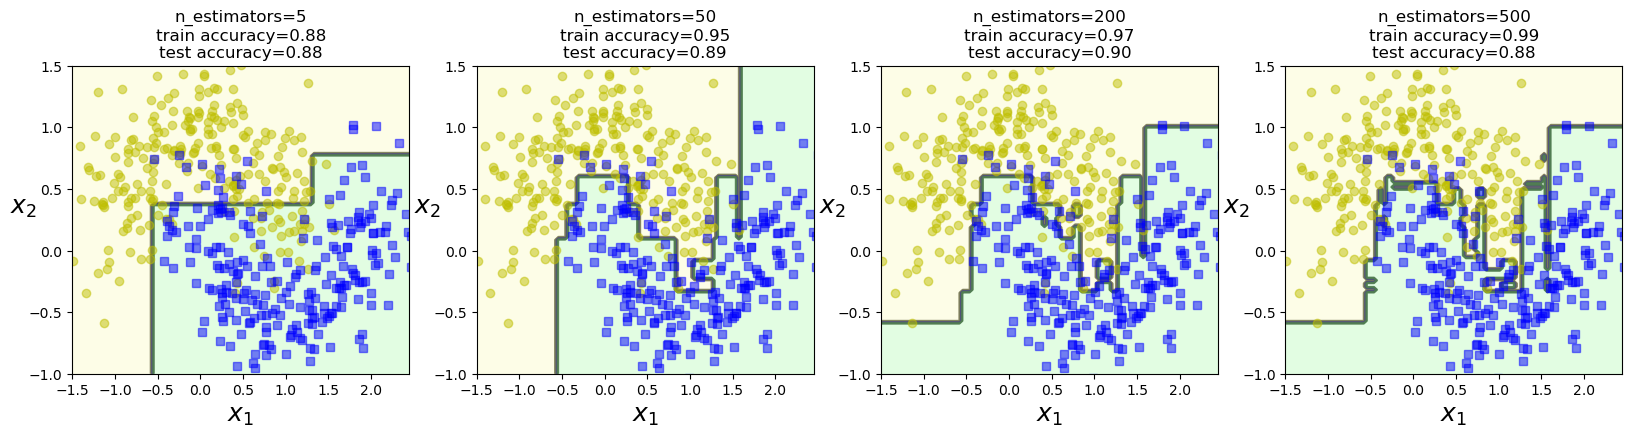

In [9]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
for i, M in enumerate([5, 50, 200, 500]):
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=M,
        algorithm="SAMME.R", learning_rate=0.5, random_state=42)
    ada_clf.fit(X_train, y_train)
    train_score = ada_clf.score(X_train, y_train)
    test_score = ada_clf.score(X_test, y_test)
    plot_decision_boundary(ada_clf, X, y, ax=axs[i])
    plt.sca(axs[i])
    plt.title(f'n_estimators={M}\ntrain accuracy={train_score:0.2f}\ntest accuracy={test_score:0.2f}')

Notice how increasing the number of estimators can make the model more accurate, but a too large number increases the risk of overfitting (see tha case with 500 estimators).

#### About the algorithm
The algorithm SAMME is a generalization of the orginal AdaBoost for multi-class problems. It is equivalent to Binary AdaBoost when the number of classes is 2 (as is the case here).
SAMME.R stands for SAMME Real and is a variant that combines the predicted probabilities for all classes, instead of just combining the final predictions.

Here is the same comparison as before, but using simple SAMME as the fitting algorithm.

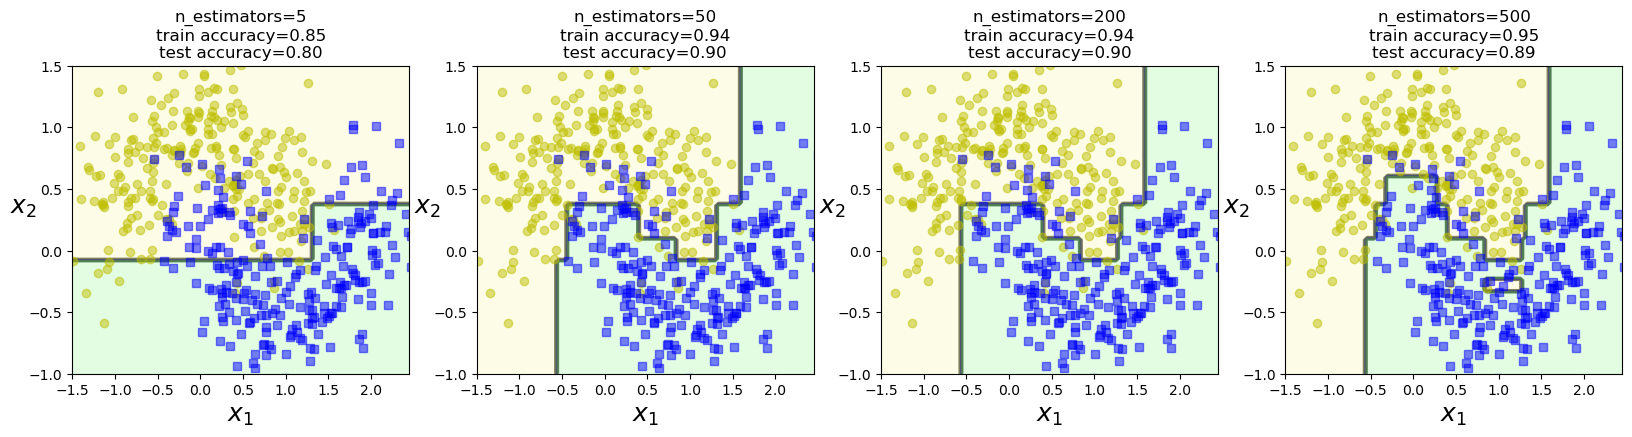

In [10]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
for i, M in enumerate([5, 50, 200, 500]):
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=M,
        algorithm="SAMME", learning_rate=0.5, random_state=42)
    ada_clf.fit(X_train, y_train)
    train_score = ada_clf.score(X_train, y_train)
    test_score = ada_clf.score(X_test, y_test)
    plot_decision_boundary(ada_clf, X, y, ax=axs[i])
    plt.sca(axs[i])
    plt.title(f'n_estimators={M}\ntrain accuracy={train_score:0.2f}\ntest accuracy={test_score:0.2f}')

## Gradient Boosting

### A simple example of Gradient Boosted Regression Trees
We will start demonstrating gradient boosting in a toy regression problem. 
Let's create a simple quadratic dataset with a single feature:

Text(0.5, 1.0, '$y=3{x_1}^2+\\epsilon$')

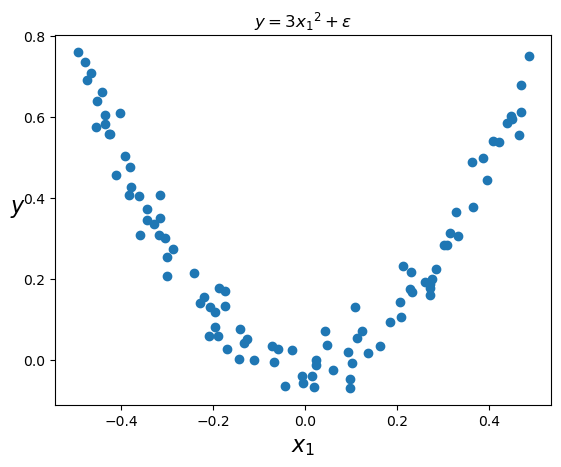

In [53]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.scatter(X,y)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16);
plt.title("$y=3{x_1}^2+\epsilon$")

Here we want our model to learn a mapping expressing the true data mean $y=3{x_1} ^2$, despite the additive noise $\epsilon$ we have included in the samples. 

Now let's train a decision tree regressor on this dataset:

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In gradient boosting we fit the learners $F_m$ to the residuals. That is, we fit:
$$F_m = \text{argmin}_F (r_m-F)^2$$

From theory, the residuals should be the negative of the gradient of $\mathcal{L}$ wrt $f$. For the squared error loss, we have seen that the negative gradient is 
$$r_m = \frac{\partial \mathcal{L}}{\partial f(x)} = y-f(x)$$

The current $f(x)=F_1(x)$ is implemented by `tree_reg1`, so that we can compute the residuals by $$r_2 = y - F_1(x)$$ and then fit $F_2$ as follows:

In [13]:
# TODO complete to compute the residual r2
r2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
# TODO fit tree_reg2 to the residual r2
tree_reg2.fit(X, r2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we fit another model $F_3$ to the residuals of the current model 
$$f_2(x) = F_1(x) + F_2(x)$$

We can compute $r_3$ as a function of $r_2$ as follows:
$$r_3 = y - f_2(x) = y - F_1(x) - F_2(x) = r_2 - F_2(x)$$

Then we can fit $F_3$ to approximate it:

In [14]:
# TODO compute the residual r3
r3 = r2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
# TODO fit tree_reg3 to the residual r3
tree_reg3.fit(X, r3)

DecisionTreeRegressor(max_depth=2, random_state=42)

To compute the final model, we sum the predictions of all 3 trees. Here is an example:

In [15]:
X_new = np.array([[0.8]])

In [16]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [17]:
y_pred

array([0.75026781])

The following plots show models learned on each iteration, alongside the ensamble model at that iteration:

In [18]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

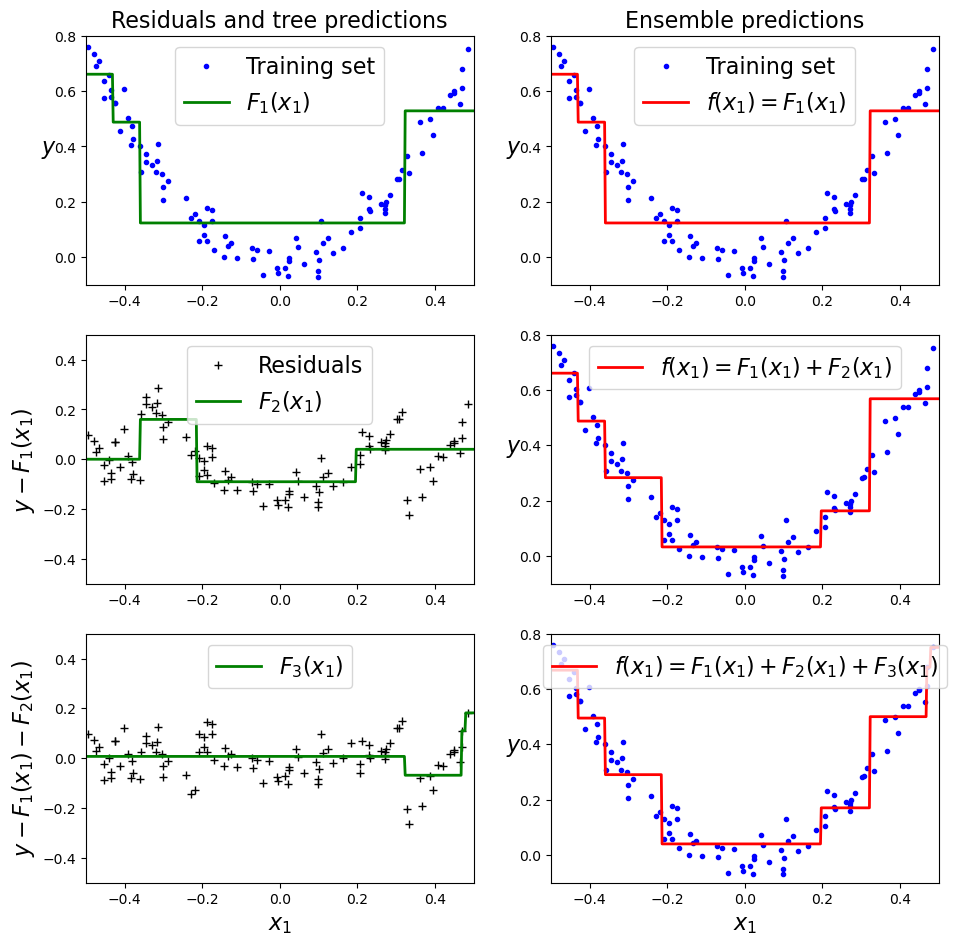

In [19]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$F_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$f(x_1) = F_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, r2, axes=[-0.5, 0.5, -0.5, 0.5], label="$F_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - F_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$f(x_1) = F_1(x_1) + F_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, r3, axes=[-0.5, 0.5, -0.5, 0.5], label="$F_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - F_1(x_1) - F_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$f(x_1) = F_1(x_1) + F_2(x_1) + F_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### Using scikit-learn to implement Gradient Boosted Trees

We can use scikit-learn's model [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) to implement the same models more easily.

Here is an example that implements the same model we just did before, using 3 trees with max-depth of 2. Note that we have combined all models with equal weight. Implicitly, we have used a learning rate of 1.0 to combine them. We can also inform this as a hyperparameter to the model constructor.

Text(0, 0.5, '$y$')

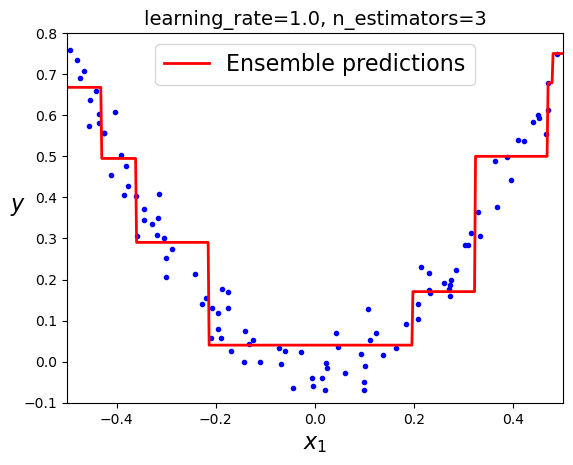

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#### About the number of estimators and the learning rate

Again, as in AdaBoost, the number of estimators is an important hyperparameter to balance under and overfitting. To few and the ensemble underfits, to many and the ensemble model can overfit.

Here is an example on the same regression data:

In [21]:
gbrt_many = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=1.0, random_state=42)
gbrt_many.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=200,
                          random_state=42)

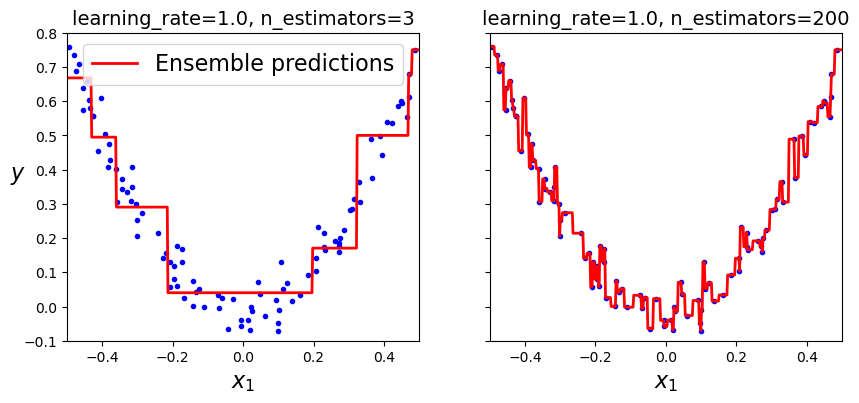

In [22]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_many], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_many.learning_rate, gbrt_many.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

When using many estimators, reducing the learning rate can be an effective way of regularizing the ensemble model by limiting the influence of each individual learner in the final prediction.

Here is the same example seen before, but with the learning rate dropped to 0.1.

In [45]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

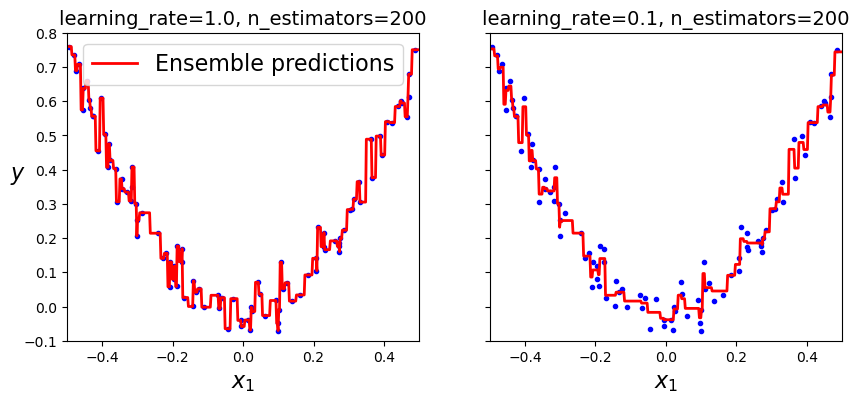

In [46]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_many], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_many.learning_rate, gbrt_many.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

#### Limiting the number of estimators with early stopping

Remember that in boosting, models are fit sequentially. Therefore one possible way to limit the number of estimators is to use a validation set to estimate generalization, and picking the number of estimators that minimizes validation error.

Here is an example using this method to choose a good number of estimators. First we train a `GradientBoostingRegressor` with many estimators.


In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

max_n_estimators = 120
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=max_n_estimators, random_state=42)
gbrt.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

Then we can compute predictions at each stage of the boosting process by using the method `staged_predict`. This will give us predictions at each of the 119 boosting iterations.

In [26]:
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
print("errors computed:", len(errors))

errors computed: 120


We take the number of estimators corresponding to the minimum of this error array (plus 1 since the first iteration starts at 2 models already).

In [27]:
best_n_estimators = np.argmin(errors) + 1

Here is a plot of this validation error curve with the minimum value indicated by a black line:

Text(0.5, 1.0, 'Validation error')

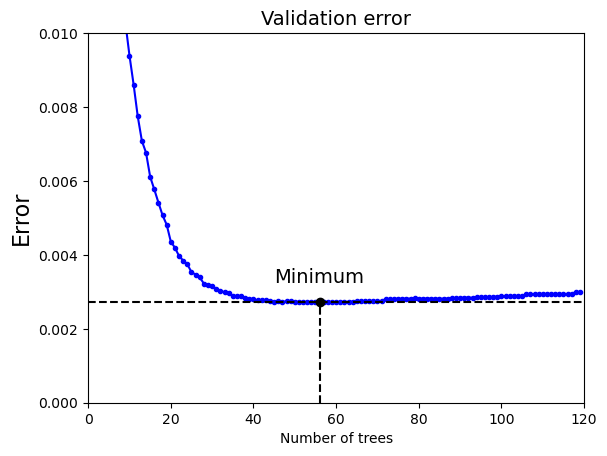

In [47]:
min_error = np.min(errors)
# plot errors x num estimators
plt.plot(errors, "b.-")
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)
# Highlight minimum point
# plot dashed lines
# vertical
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
# horizontal
plt.plot([0, max_n_estimators], [min_error, min_error], "k--")
# plot crossing point and annotation
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, max_n_estimators, 0, 0.01])

Now we can train a gradient boosted model with the best number of estimators:

In [29]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

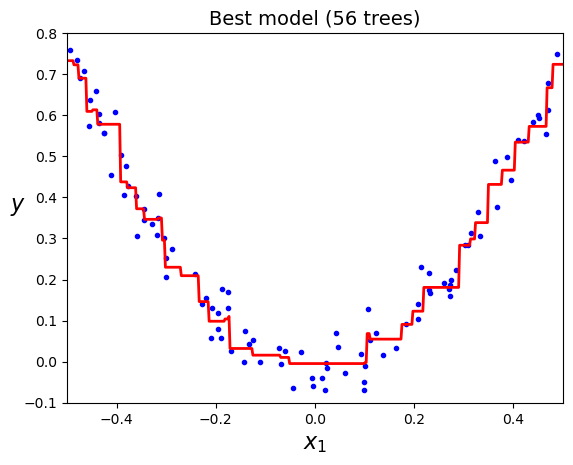

In [30]:
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

#### Early stopping with incremental fit

In fact it is not necessary to fit the boosting all the way through to only then evaluate validation errors. We can iteratively add more estimators and continue fitting from the previous model state by using the parameter `warm_start=True`.

This way we can loop through an increasing series of values for the `n_estimators` parameter, calling fit and evaluating performances on the validation set.

Since we won't be trying values all the way until clear overfitting, it is intereting to include a patience mechanism into our early stopping. 
That is, once validation error stops improving, we wait a certain number of iterations (say, 5 ) before we stop training.

Here is an example implementing incremental fit and early stopping.

In [31]:
gbrt = GradientBoostingRegressor(
    max_depth=2, 
    warm_start=True,  # important: set this to reuse previously trained models
    random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    # Increase the number of estimators
    gbrt.n_estimators = n_estimators
    # Fit will be incremental due to warm_start=True
    gbrt.fit(X_train, y_train)
    # Now compute validation error and check early stopping criteria
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [32]:
print(gbrt.n_estimators)

61


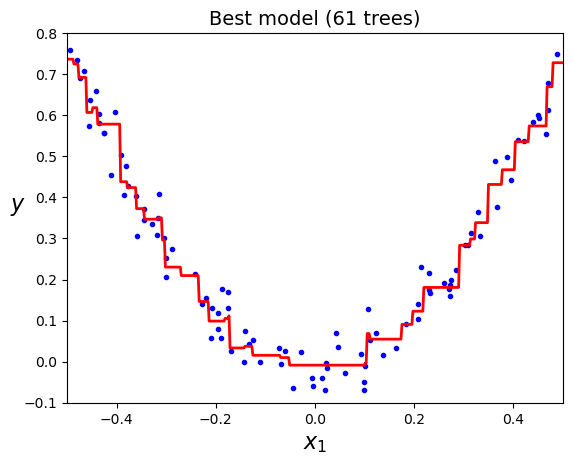

In [33]:
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % gbrt.n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

In [34]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


### Using XGBoost

XGBoost is a popular version of gradient boosted trees that includes many optmizations and adds many regularization options to the basic Gradient Boosted Trees.

In [35]:
try:
    import xgboost
except ModuleNotFoundError:
    !pip install xgboost
    import xgboost

It has a scikit-learn-like API, as you can check in the documentation for [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor).

In [ ]:
?xgboost.XGBRegressor

Full documentation for all parameters can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html).


Here is an example using XGBoost to solve the same regression problem we have been solving with scikit-learn's GBRT model.

In [37]:
xgb_reg = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.004000408205406276


#### Early stopping on XGBoost
In XGBoost you can inform a validation set to the `fit` function in order to implement early stopping.
To activate this, you should: 
 - inform the parameter `early_stopping_rounds` when creating an isntance of `XGBRegressor`. It corresponds to the "patience" parameter.
 - pass an `eval_set` into the `fit` call.

Here is an example:

In [42]:
# instantiate the model
xgb_reg = xgboost.XGBRegressor(
    objective='reg:squarederror', 
    early_stopping_rounds=2, # the patience parameter
    random_state=42)
# call fit with the eval set
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)]  # the validation set
            )
# Now we print the validation MSE of the final model.
# Is it better than without useing early stopping?
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print(f"Final Validation MSE:{val_error:0.5g}")

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Final Validation MSE:0.0026309


#### Computational optimizations
XGBoost implementations are optimized for faster performance and can profit from hardware acceleration.

Here we use the Ipython's `%timeit` magic to compare average running times for both  XGBoost's and scikit-learn's implementations.

In [39]:
%timeit xgboost.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train) if xgboost is not None else None

77.6 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

35.3 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


On a standard Colab runtime, XGBoost runs around 3x faster than scikit-learn.